In [1]:
#Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import duckdb

In [2]:
#Read in the dataset 
df = pd.read_csv('ds_challenge_v2_1_data.csv')
df.head(10)

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN
5,6,Strark,android web,Referral,1/18/16,1/18/16,1/22/16,Cadillac,DTS,2006.0,NaN
6,7,Strark,ios web,Paid,1/14/16,1/16/16,1/21/16,Toyota,Prius V,2014.0,1/23/16
7,8,Strark,ios web,Referral,1/26/16,2/5/16,NaN,NaN,NaN,NaN,NaN
8,9,Strark,NaN,Referral,1/5/16,NaN,NaN,NaN,NaN,NaN,NaN
9,10,Berton,ios web,Paid,1/25/16,NaN,NaN,NaN,NaN,NaN,NaN


<img src="Screenshot 2025-04-12 at 10.50.36 AM.png" width="" align="" />

In [3]:
# Check what percentage of signups happened in this data set
# Exploratory Data Analysis
df_drivers = df[df['first_completed_date'].notnull()]
df_nondrivers = df[df['first_completed_date'].isnull()]
print(len(df_drivers)/len(df)) #0.11223
print(len(df_nondrivers)/len(df)) #0.88776
print(len(df))

df_explore = df.copy()
df_explore["is_driver"] = df_explore['first_completed_date'].notnull().map({True: 'Driver', False: 'Non-driver'})
df_summary = df_explore['is_driver'].value_counts().reset_index()
df_summary.columns = ['Driver Type', 'Count']
df_summary.rename(index={'Non-driver': 'Driver'})
df_summary

0.11223276823759624
0.8877672317624038
54681


,Driver Type,Count
0,Non-driver,48544
1,Driver,6137


In [4]:
_dntk.DeepnoteChart(df_summary, """{"layer":[{"layer":[{"layer":[{"mark":{"clip":true,"type":"arc","color":"#2266D3","tooltip":true,"innerRadius":{"expr":"0"},"outerRadius":{"expr":"min(width, height) / 2"}},"encoding":{"color":{"axis":{"grid":false},"sort":null,"type":"nominal","field":"Driver Type","scale":{"scheme":"deepnote10"}},"order":{"axis":{"grid":false,"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"sort":"descending","type":"quantitative","field":"Count","scale":{},"stack":true,"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"},"theta":{"axis":{"grid":false,"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"type":"quantitative","field":"Count","scale":{},"stack":true,"format":{"type":"default","decimals":null},"aggregate":"sum","formatType":"numberFormatFromNumberType"}},"transform":[]}]}],"resolve":{"scale":{"color":"independent"}}}],"title":"","config":{"legend":{"disable":false}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"seriesNames":["Count"],"seriesOrder":[0],"specSchemaVersion":2,"tooltipDefaultMode":true}}""")

> Of the Uber drivers who signed up (sign_up_date not null), only a small percentage actually started driving - specifically 11.22% out of n = 54681 drivers.

In [5]:
# Comparing drivers vs. nondrivers
df_explore.columns
print(df_explore.columns)
x = df_explore.groupby('is_driver')['vehicle_year'].mean().round(0).reset_index()
x

Index(['id', 'city_name', 'signup_os', 'signup_channel', 'signup_date',
       'bgc_date', 'vehicle_added_date', 'vehicle_make', 'vehicle_model',
       'vehicle_year', 'first_completed_date', 'is_driver'],
      dtype='object')


,is_driver,vehicle_year
0,Driver,2011.0
1,Non-driver,2010.0


In [6]:
!pip install geocoder==1.38.1


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
print(df_explore["city_name"].value_counts())
print("There's 3 specific cities in this data set - Strark, Berton, Wrouver")


city_name
Strark     29557
Berton     20117
Wrouver     5007
Name: count, dtype: int64
There's 3 specific cities in this data set - Strark, Berton, Wrouver


In [8]:
# Updated Preprocessing 
# Convert string data type to date data type
df['bgc_date'] = pd.to_datetime(df['bgc_date']).dt.date
df['signup_date'] = pd.to_datetime(df['signup_date']).dt.date
df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date']).dt.date

# Feature Engineering - Adding date differences
df["bgc_signup_diff"] = df["bgc_date"] - df["signup_date"]
df["vehicle_signup_diff"] = df["vehicle_added_date"] - df["signup_date"]
df_completed_reqs = df[df["signup_date"].notna() & df["bgc_date"].notna() & df["vehicle_added_date"].notna()]




# Create binary target variable
df_completed_reqs['started_driving'] = df_completed_reqs['first_completed_date'].notnull().astype(int)

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

for col in ['city_name', 'signup_os', 'signup_channel']:
    df_completed_reqs[col] = df_completed_reqs[col].fillna('Unknown')
    df_completed_reqs[col] = LabelEncoder().fit_transform(df_completed_reqs[col])

# Fill missing vehicle_year with -1
df_completed_reqs['vehicle_year'] = df_completed_reqs['vehicle_year'].fillna(-1)

# Select final feature set
feature_cols = ['city_name', 'signup_os', 'signup_channel',
                'vehicle_year', 'bgc_signup_diff', 'vehicle_signup_diff']

X = df_completed_reqs[feature_cols]
y = df_completed_reqs['started_driving']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/tmp/ipykernel_1814/4259950493.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['bgc_date'] = pd.to_datetime(df['bgc_date']).dt.date
/tmp/ipykernel_1814/4259950493.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['signup_date'] = pd.to_datetime(df['signup_date']).dt.date
/tmp/ipykernel_1814/4259950493.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['vehicle_added_date'] = pd.to_datetime(df['vehicle_added_date']).dt.date
/tmp/ipykernel_1814/4259950493.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

<img src="Screenshot 2025-04-12 at 10.50.54 AM.png" width="" align="" />

<img src="Screenshot 2025-04-12 at 10.51.05 AM.png" width="" align="" />

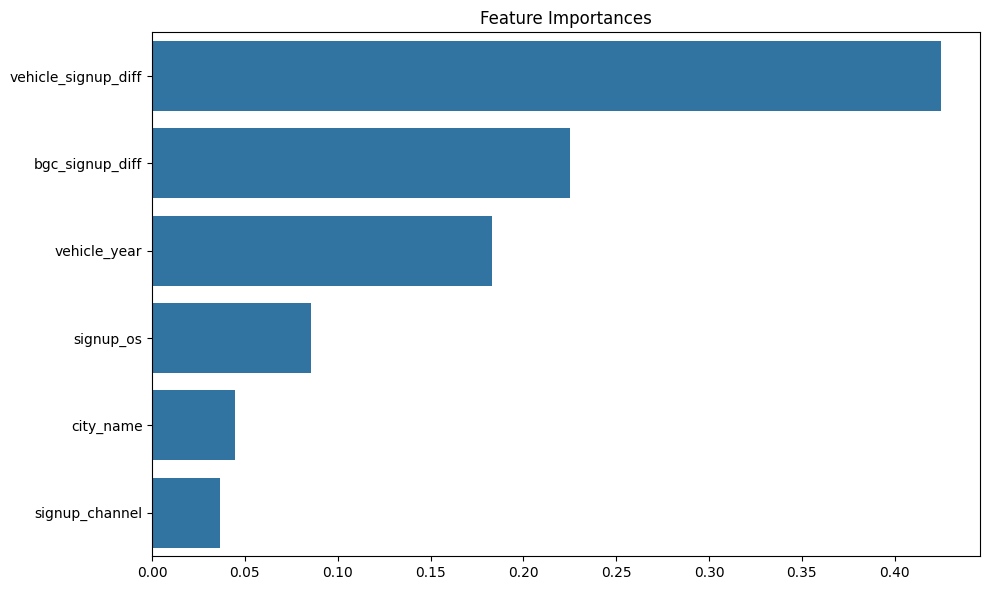

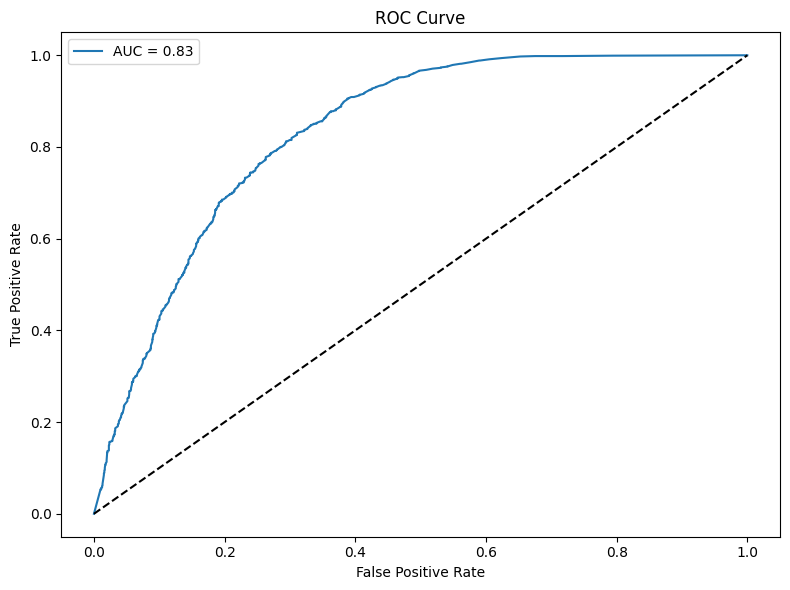

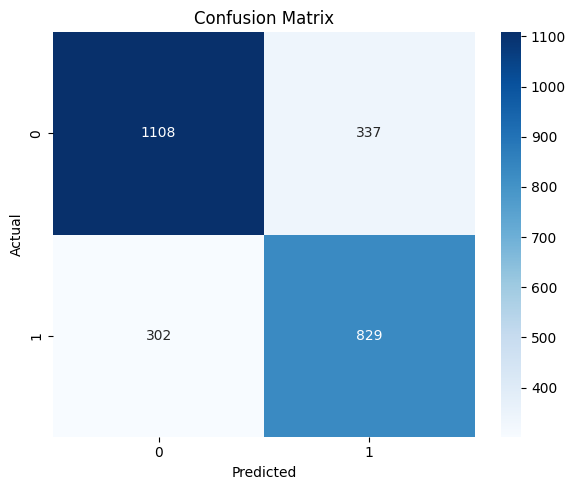

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.77      0.78      1445
           1       0.71      0.73      0.72      1131

    accuracy                           0.75      2576
   macro avg       0.75      0.75      0.75      2576
weighted avg       0.75      0.75      0.75      2576



In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Handle timedelta columns by converting to integer (number of days)
X_train = X_train.copy()
X_test = X_test.copy()

# Ensure values are converted to timedelta first, then extract days if needed
X_train['bgc_signup_diff'] = pd.to_timedelta(X_train['bgc_signup_diff']).dt.days
X_train['vehicle_signup_diff'] = pd.to_timedelta(X_train['vehicle_signup_diff']).dt.days
X_test['bgc_signup_diff'] = pd.to_timedelta(X_test['bgc_signup_diff']).dt.days
X_test['vehicle_signup_diff'] = pd.to_timedelta(X_test['vehicle_signup_diff']).dt.days

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature importance plot
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=[feature_cols[i] for i in indices])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# ROC Curve
y_prob = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

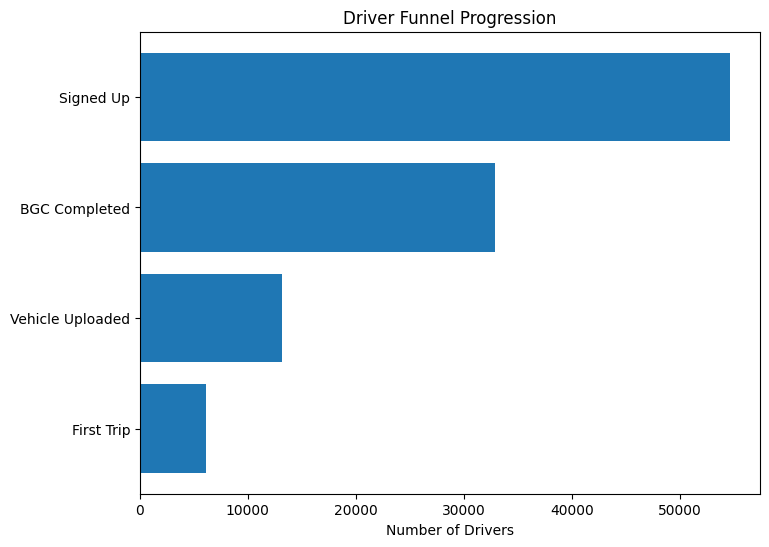

In [10]:
import matplotlib.pyplot as plt
df['bgc_completed'] = df['bgc_date'].notna().astype(int)
df['vehicle_uploaded'] = df['vehicle_added_date'].notna().astype(int)
df['first_trip_completed'] = df['first_completed_date'].notna().astype(int)
funnel_counts = {
    'Signed Up': len(df),
    'BGC Completed': df['bgc_completed'].sum(),
    'Vehicle Uploaded': df['vehicle_uploaded'].sum(),
    'First Trip': df['first_trip_completed'].sum()
}

plt.figure(figsize=(8, 6))
plt.barh(list(funnel_counts.keys()), list(funnel_counts.values()))
plt.title('Driver Funnel Progression')
plt.xlabel('Number of Drivers')
plt.gca().invert_yaxis()
plt.show()

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
XGBoost Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1445
           1       0.72      0.83      0.77      1131

    accuracy                           0.78      2576
   macro avg       0.79      0.79      0.78      2576
weighted avg       0.79      0.78      0.79      2576

ROC AUC: 0.8542851810719608


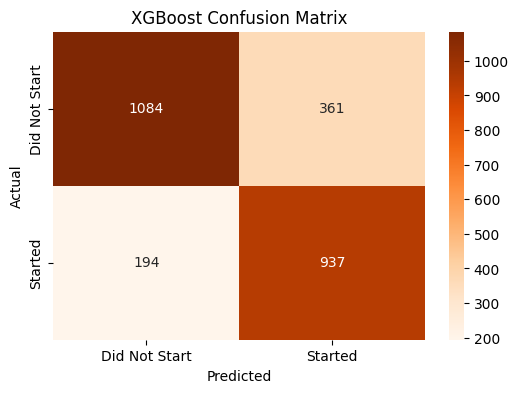

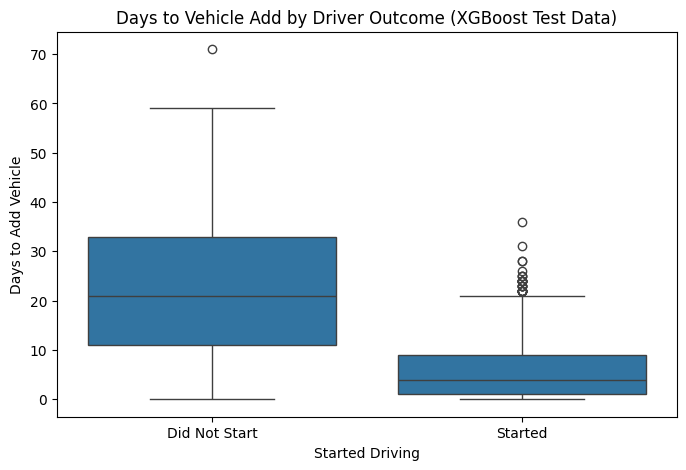

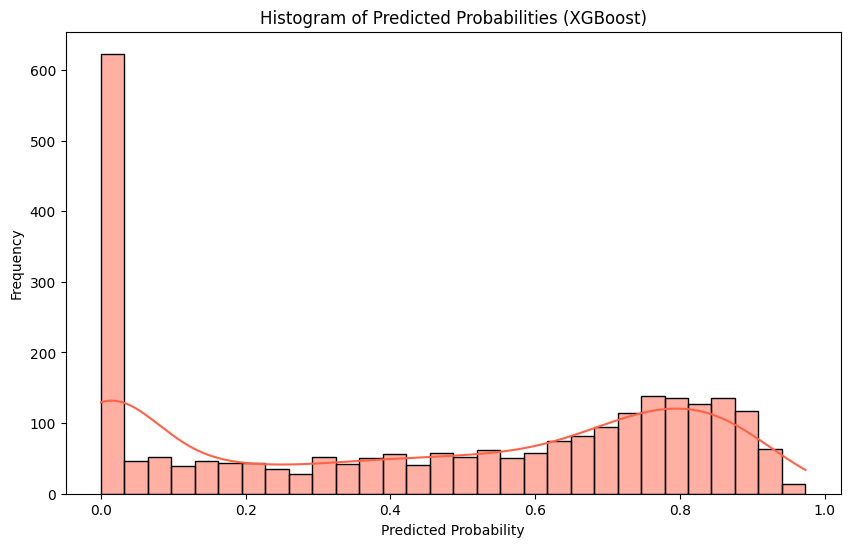

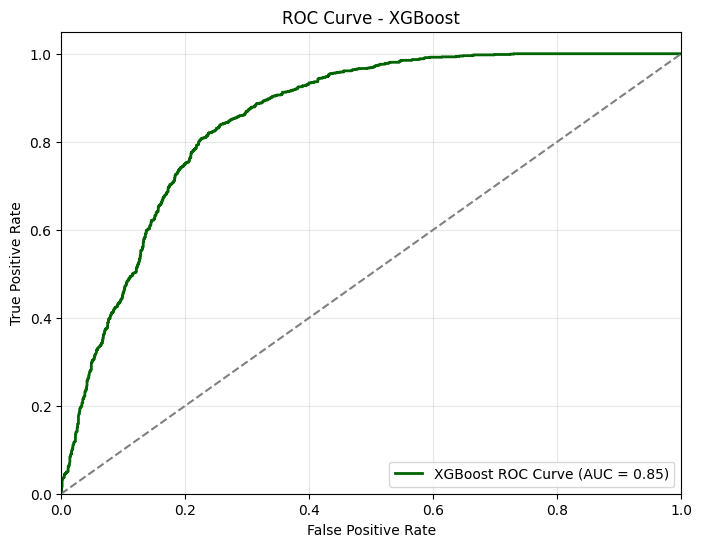

In [11]:
# Import necessary libraries
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("XGBoost Report:")
print(classification_report(y_test, xgb_pred))
print("ROC AUC:", roc_auc_score(y_test, xgb_proba))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Did Not Start', 'Started'], 
            yticklabels=['Did Not Start', 'Started'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Create df_test for feature analysis
df_test = X_test.copy()
df_test['started_driving'] = y_test.values
df_test['xgb_proba'] = xgb_proba

# Example: Map signup day (you can add this during preprocessing if needed)
df_test['signup_day'] = df.loc[df_test.index, 'signup_date'].apply(lambda x: x.weekday())
df_test['signup_day'] = df_test['signup_day'].map({0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'})

signup_day_summary_xgb = df_test.groupby('signup_day')['started_driving'].mean().reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plotting days to add vehicle (make sure it's included in original df)
# The vehicle_signup_diff is already in integer days from previous preprocessing
df_test['days_to_vehicle_add'] = df_test['vehicle_signup_diff']  # Remove .dt.days as it's already in days format

plt.figure(figsize=(8, 5))
# Now filter using the integer days
sns.boxplot(data=df_test[df_test['days_to_vehicle_add'].notna()], 
            x='started_driving', y='days_to_vehicle_add')
plt.title("Days to Vehicle Add by Driver Outcome (XGBoost Test Data)")
plt.xlabel("Started Driving")
plt.ylabel("Days to Add Vehicle")
plt.xticks([0, 1], ['Did Not Start', 'Started'])
plt.show()

# Histogram of predicted probabilities
plt.figure(figsize=(10, 6))
sns.histplot(xgb_proba, bins=30, kde=True, color='tomato')
plt.title("Histogram of Predicted Probabilities (XGBoost)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkgreen', lw=2, label=f"XGBoost ROC Curve (AUC = {roc_auc_xgb:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1445
           1       0.72      0.82      0.77      1131

    accuracy                           0.78      2576
   macro avg       0.78      0.79      0.78      2576
weighted avg       0.79      0.78      0.78      2576

ROC AUC: 0.8594791637984573


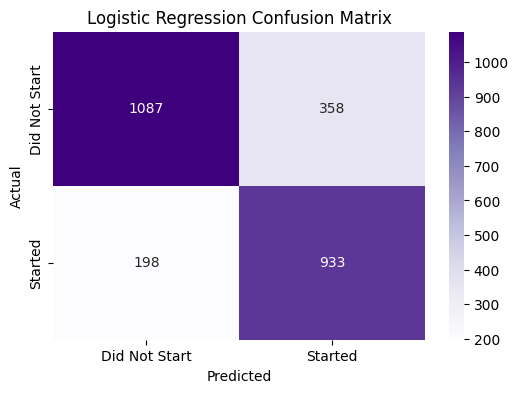

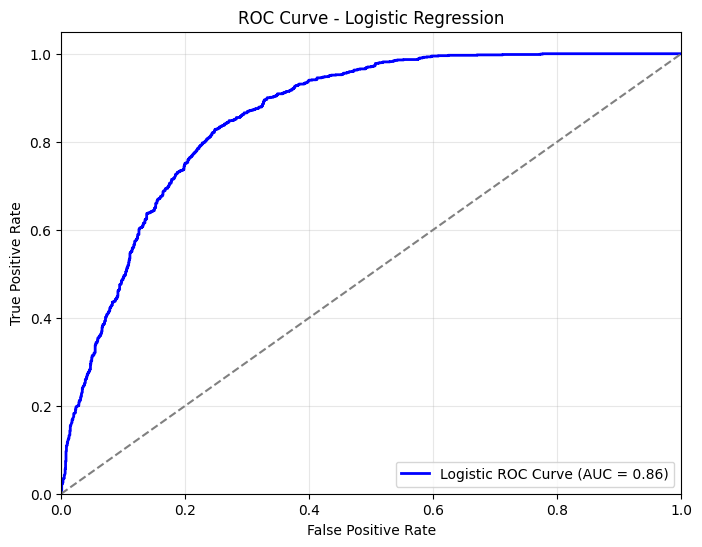

In [12]:
# # Logistic Regression Model
# log_model = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='lbfgs')
# log_model.fit(X_train, y_train)
# log_pred = log_model.predict(X_test)
# log_proba = log_model.predict_proba(X_test)[:, 1]

# print("Logistic Regression Report:")
# print(classification_report(y_test, log_pred))
# print("ROC AUC:", roc_auc_score(y_test, log_proba))

# # Generate confusion matrix
# cm_log = confusion_matrix(y_test, log_pred)

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(6, 4))
# sns.heatmap(cm_log, annot=True, fmt='d', cmap='Purples', 
#             xticklabels=['Did Not Start', 'Started'], 
#             yticklabels=['Did Not Start', 'Started'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Logistic Regression Confusion Matrix')
# plt.show()

# # Compute ROC curve and AUC
# fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
# roc_auc_log = auc(fpr_log, tpr_log)

# # Plot
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f"Logistic ROC Curve (AUC = {roc_auc_log:.2f})")
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve - Logistic Regression")
# plt.legend(loc="lower right")
# plt.grid(alpha=0.3)
# plt.show()


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt


# Train logistic regression model
log_model = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='lbfgs')
log_model.fit(X_train, y_train)

# Predict
log_pred = log_model.predict(X_test)
log_proba = log_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Logistic Regression Report:")
print(classification_report(y_test, log_pred))
print("ROC AUC:", roc_auc_score(y_test, log_proba))

# Confusion Matrix
cm_log = confusion_matrix(y_test, log_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Did Not Start', 'Started'],
            yticklabels=['Did Not Start', 'Started'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# ROC Curve
fpr_log, tpr_log, _ = roc_curve(y_test, log_proba)
roc_auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, color='blue', lw=2, label=f"Logistic ROC Curve (AUC = {roc_auc_log:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips.

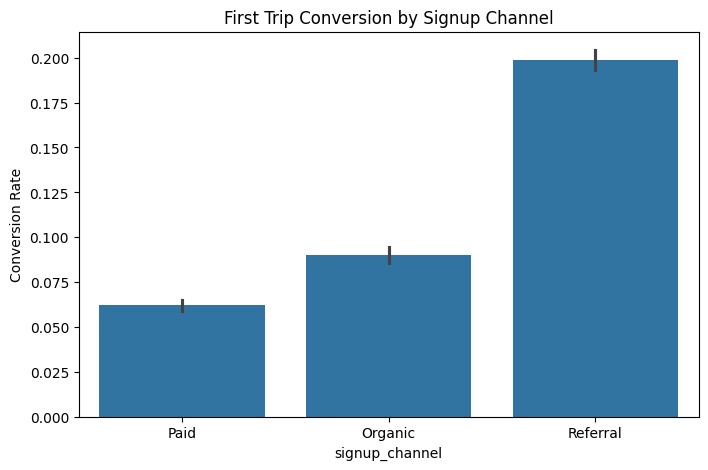

In [13]:
import seaborn as sns

# Signup channel
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='signup_channel', y='first_trip_completed')
plt.title('First Trip Conversion by Signup Channel')
plt.ylabel('Conversion Rate')
plt.show()

In [14]:
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint

#random_grid = {
#    'n_estimators': randint(100, 400),
#    'max_depth': [None] + list(range(10, 40, 10)),
#    'min_samples_split': randint(2, 11),
#    'min_samples_leaf': randint(1, 5),
#    'max_features': ['sqrt', 'log2']
#}

#random_search = RandomizedSearchCV(
#    estimator=RandomForestClassifier(random_state=42),
#    param_distributions=random_grid,
#    n_iter=50,  # number of random settings to try
#    cv=5,
#    scoring='roc_auc',
#    random_state=42,
#    n_jobs=-1,
#    verbose=2
#)

#random_search.fit(X_train, y_train)
# Ensamble Model
#print(random_search.best_score_)
#print(random_search.best_params_)
#{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 382}


In [15]:
#from sklearn.model_selection import RandomizedSearchCV
#from scipy.stats import randint
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'C': [0.001, 0.01, 0.1, 1, 10, 100],         # Inverse of regularization strength
#    'penalty': ['l2'],                           # 'l1' requires solver='liblinear'
#    'solver': ['lbfgs'],                         # 'lbfgs' supports only l2 penalty
#    'max_iter': [5000, 10000]
#}

#logreg = LogisticRegression()

#grid_search_log = GridSearchCV(
#    estimator=logreg,
#    param_grid=param_grid,
#    scoring='roc_auc',
#    cv=5,
#    n_jobs=-1,
#    verbose=2
#)

#grid_search_log.fit(X_train, y_train)

#print("Best Parameters:", grid_search_log.best_params_)

#best_log_model = grid_search_log.best_estimator_
#y_pred_log = best_log_model.predict(X_test)
#y_proba_log = best_log_model.predict_proba(X_test)[:, 1]

#from sklearn.metrics import classification_report, roc_auc_score
#print(classification_report(y_test, y_pred_log))
#print("Logistic Regression ROC AUC:", roc_auc_score(y_test, y_proba_log))

In [16]:
#param_grid = {
#    'n_estimators': [100, 200],
#    'max_depth': [3, 5, 7],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'subsample': [0.7, 1.0],
#    'colsample_bytree': [0.7, 1.0]
#}
#xgb = XGBClassifier(
#    use_label_encoder=False,
#    eval_metric='logloss',
#    random_state=42
#)

#grid_search_xgb = GridSearchCV(
#    estimator=xgb,
#    param_grid=param_grid,
#    scoring='roc_auc',
#    cv=5,
#    n_jobs=-1,
#    verbose=2
#)

#grid_search_xgb.fit(X_train, y_train)
#print("Best Parameters:", grid_search_xgb.best_params_)

#best_xgb_model = grid_search_xgb.best_estimator_
#y_pred_xgb = best_xgb_model.predict(X_test)
#y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

#from sklearn.metrics import classification_report, roc_auc_score
#print(classification_report(y_test, y_pred_xgb))
#print("XGBoost ROC AUC:", roc_auc_score(y_test, y_proba_xgb))

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:23:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      1445
           1       0.73      0.83      0.78      1131

    accuracy                           0.79      2576
   macro avg       0.79      0.79      0.79      2576
weighted avg       0.80      0.79      0.79      2576

Ensemble ROC AUC: 0.8643167237249089


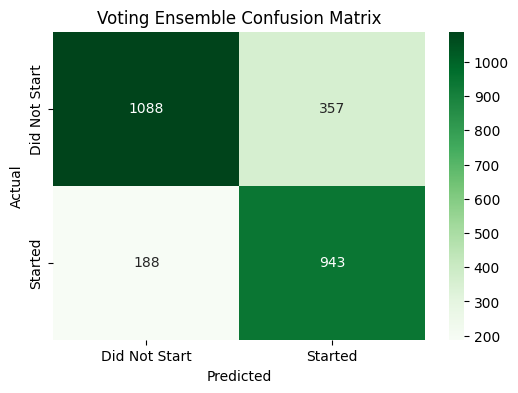

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

log_model = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='lbfgs')
rf_model = RandomForestClassifier(n_estimators=382, random_state=42, max_depth=10, max_features='sqrt', min_samples_leaf=1, min_samples_split=10)
xgb_model = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss', 
    colsample_bytree=1.0,  # Fixed syntax here
    learning_rate=0.1,     # Fixed syntax here
    max_depth=3, 
    n_estimators=100, 
    subsample=0.7, 
    random_state=42
)

ensemble_model = VotingClassifier(
    estimators=[
        ('logreg', log_model),
        ('rf', rf_model),
        ('xgb', xgb_model)
    ],
    voting='soft'  # 'soft' uses predicted probabilities, generally better
)
ensemble_model.fit(X_train, y_train)
y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_test, y_pred_ensemble))
print("Ensemble ROC AUC:", roc_auc_score(y_test, y_proba_ensemble))
# Compute confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Did Not Start', 'Started'],
            yticklabels=['Did Not Start', 'Started'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Ensemble Confusion Matrix')
plt.show()